In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-97fvjvk_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-97fvjvk_
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=a01f10e3f78ed5c797cd4281db1651662b81db59a5167bc93449a6ea21826be0
  Stored in directory: /tmp/pip-ephem-wheel-cache-gstuo9uu/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
mkdir: cannot create directory ‘images’: File exists
--2025-11-25 12:38:16--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving

[0, 0, 638, 327]


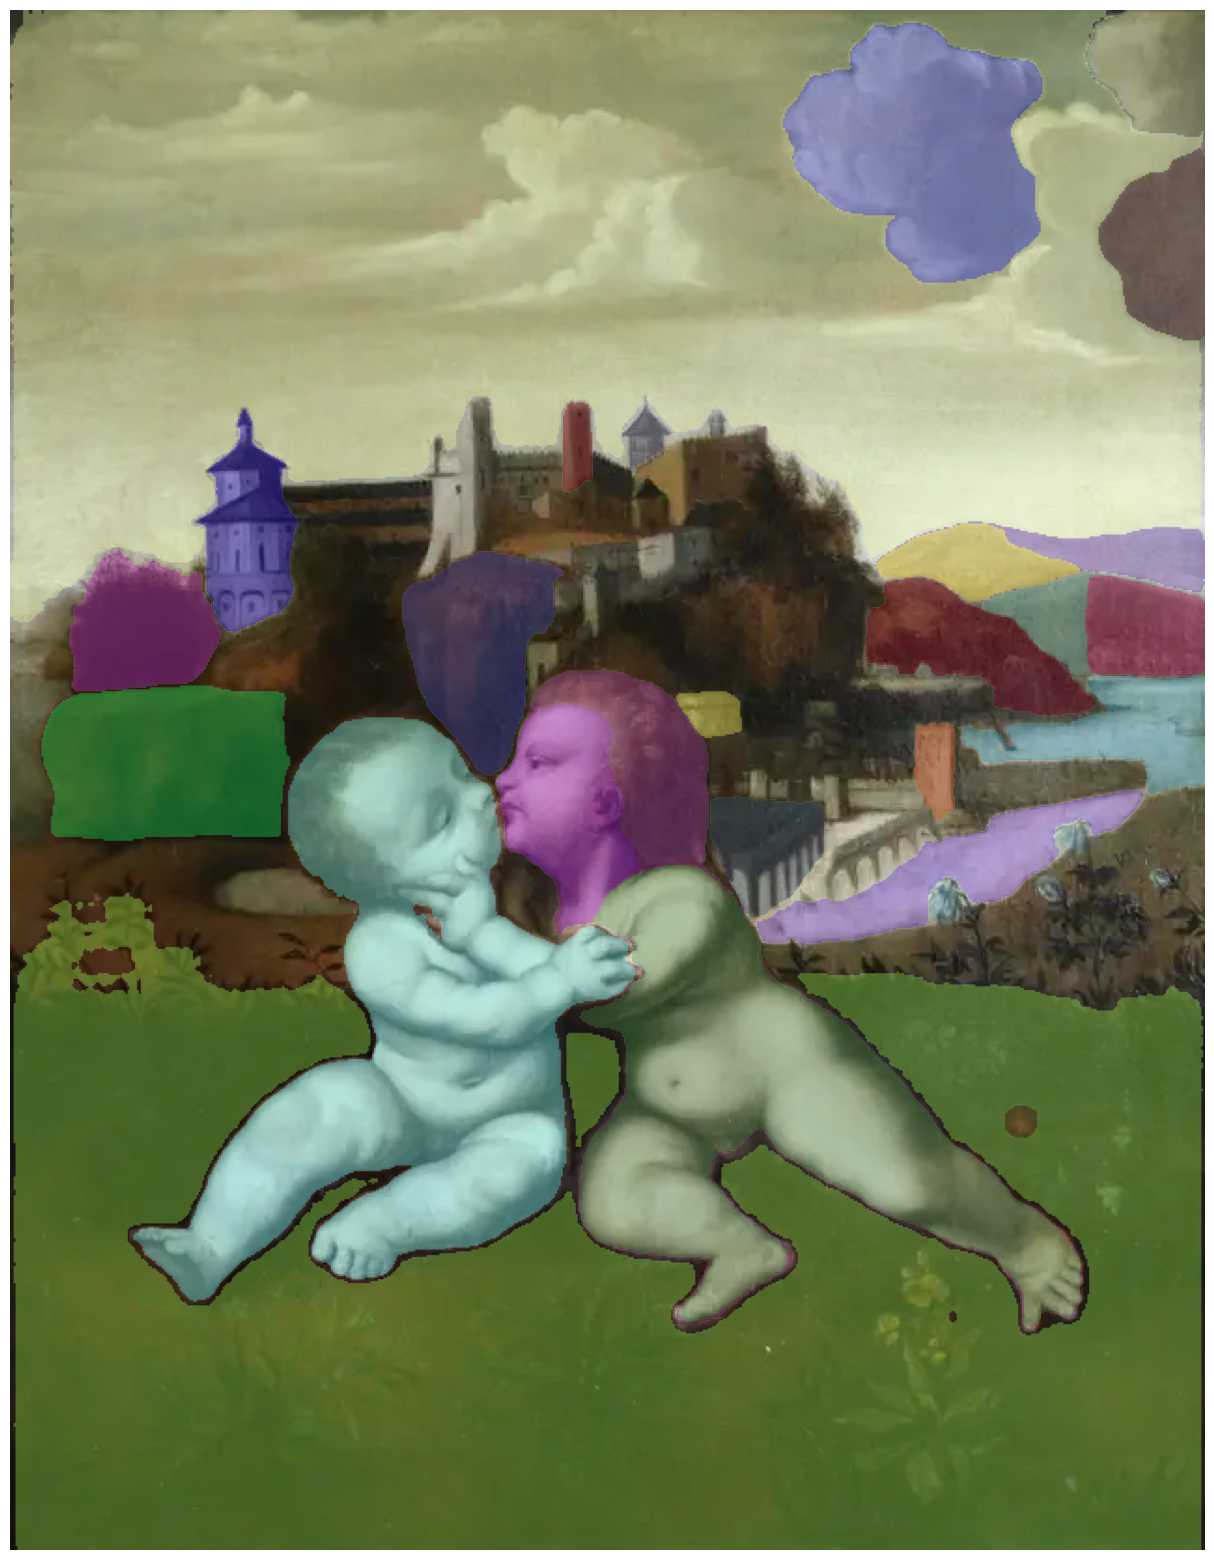

In [168]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
#from https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

#cpu if run locally, cuda otherwise
device = "cuda"
model_type = "vit_h"
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam,  pred_iou_thresh=0.95,stability_score_thresh=0.95, points_per_side=16 )
image = cv2.imread("images/image7.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(image)
print(masks[0].get("bbox"))
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()



In [ ]:
!pip install pyefd


In [169]:
from skimage import io, color
#allows to modify the sensitivity of the model (i.e the certainty level for each separate segment).
#The lower pred_iou_thresh and stability_score_thresh are, the more masks the model will generate
mask_generator = SamAutomaticMaskGenerator(sam, pred_iou_thresh=0.98,stability_score_thresh=0.95, points_per_side=8)
image = cv2.imread("images/image3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image2 = cv2.imread("images/image4.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
masks = mask_generator.generate(image)
masks2 = mask_generator.generate(image2)
print(len(masks))
print(len(masks2))

2
10


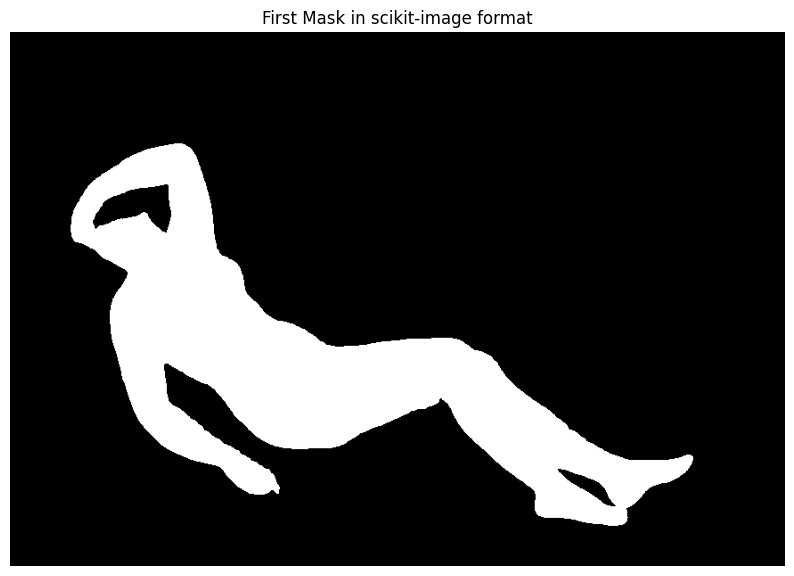

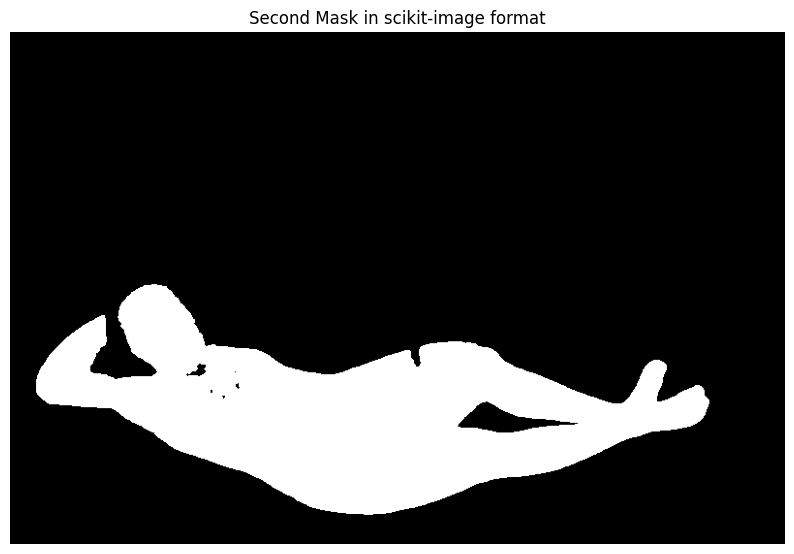

In [175]:
def mask_skimage(masks):
  skimage_masks = []
  for mask in masks:
      # The segmentation mask is a boolean numpy array
      segmentation = mask['segmentation']
      # Convert the boolean mask to an image (e.g., grayscale)
      # You can adjust this based on how you want to represent the mask in scikit-image
      skimage_mask = segmentation.astype(np.uint16)  # Convert to 0-255 grayscale image
      skimage_masks.append(skimage_mask)
  return skimage_masks

skimage_masks = mask_skimage(masks)
skimage_masks2 = mask_skimage(masks2)

# Now you have a list of masks in scikit-image format (numpy arrays)
# You can further process or save these masks as needed
# For example, to display the first mask:
plt.figure(figsize=(10, 10))
plt.imshow(skimage_masks[0], cmap='gray')
plt.title("First Mask in scikit-image format")
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(skimage_masks2[0], cmap='gray')
plt.title("Second Mask in scikit-image format")
plt.axis('off')
plt.show()

# Or save the first mask as an image file:

In [14]:
!pip install pyefd

In [171]:

from bz2 import compress
from typing import Any, Callable, Optional

import numpy as np
import torch
from torch import Tensor
from torch import nn as nn
from torchvision.utils import make_grid


FFT_MEASURE_MAX = np.sqrt(np.power(0.5, 2) + np.power(0.5, 2))

def fill_ratio(np_img):

    fill_ratio = np_img.sum().item() / np.ones_like(np_img).sum().item()

    return 1 - fill_ratio, None


def compression_measure(
    np_img,
    fill_ratio_norm=False,
) -> tuple[float, Optional[Tensor]]:

    np_img_bytes = np_img.tobytes()
    compressed = compress(np_img_bytes)

    complexity = len(compressed) / len(np_img_bytes)

    if fill_ratio_norm:
        fill_ratio = np_img.sum().item() / np.ones_like(np_img).sum().item()
        return complexity * (1 - fill_ratio), None

    return complexity, None


def fft_measure(np_img):

    fft = np.fft.fft2(np_img)

    fft_abs = np.abs(fft)

    n_h, n_w = fft.shape  # Get both height (n_h) and width (n_w) dimensions

    pos_f_idx_h = n_h // 2
    pos_f_idx_w = n_w // 2

    df_h = np.fft.fftfreq(n=n_h)  # Frequencies for height dimension
    df_w = np.fft.fftfreq(n=n_w)  # Frequencies for width dimension

    # Sum of amplitudes in the positive frequency quadrant
    amplitude_sum = fft_abs[:pos_f_idx_h, :pos_f_idx_w].sum()

    if amplitude_sum == 0:
        return 0.0, None # Avoid division by zero

    # Calculate mean frequencies
    # For x-frequency, broadcast df_w across rows
    mean_x_freq = (fft_abs[:pos_f_idx_h, :pos_f_idx_w] * df_w[:pos_f_idx_w]).sum() / amplitude_sum
    # For y-frequency, broadcast df_h across columns
    mean_y_freq = (fft_abs[:pos_f_idx_h, :pos_f_idx_w].T * df_h[:pos_f_idx_h]).T.sum() / amplitude_sum

    mean_freq = np.sqrt(np.power(mean_x_freq, 2) + np.power(mean_y_freq, 2))

    # mean frequency in range 0 to np.sqrt(0.5^2 + 0.5^2)
    return mean_freq / FFT_MEASURE_MAX, None


def vae_reconstruction_measure(
    img: Tensor,
    model_gb: nn.Module,
    model_lb: nn.Module,
    fill_ratio_norm=False,
) -> tuple[float, Optional[Tensor]]:
    model_gb.eval()
    model_lb.eval()

    with torch.no_grad():
        mask = img.to(model_gb.device)  # type: ignore

        recon_gb: Tensor
        recon_lb: Tensor

        recon_gb, _, _ = model_gb(mask)
        recon_lb, _, _ = model_lb(mask)

        abs_px_diff = (recon_gb - recon_lb).abs().sum().item()

        complexity = abs_px_diff / mask.sum()

        if fill_ratio_norm:
            complexity *= mask.sum().item() / torch.ones_like(mask).sum().item()

        return (
            complexity,
            make_grid(
                torch.stack(
                    [mask[0], recon_gb.view(-1, 64, 64), recon_lb.view(-1, 64, 64)]
                ).cpu(),
                nrow=1,
                padding=0,
            ),
        )


def combined_complexity(mask):
  return (compression_measure(mask)[0] + 0.025*fft_measure(mask)[0])*100

In [172]:
from pyefd import elliptic_fourier_descriptors
import cv2
import numpy as np

print(fft_measure(skimage_masks[0]))
# Function to find contours in a binary mask
def find_contours(mask):
    # Find contours in the binary mask
    # Use cv2.RETR_EXTERNAL to retrieve only the outer contours
    # Use cv2.CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return []
    # Find the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    return [largest_contour] # Return as a list containing only the largest contour

# Get contours for the selected masks
contours1 = []
contours2 = []
complexity1 = []
complexity2 = []

for mask in skimage_masks:
    l = find_contours(mask)
    complexity1.append(combined_complexity(mask))
    if l:
        # Ensure each contour is a single array of points for simplicity
        contours1.append(l) # Use extend as find_contours returns a list containing one contour

for mask in skimage_masks2:
    l = find_contours(mask)
    complexity2.append(combined_complexity(mask))
    if l:
        contours2.append(l) # Use extend as find_contours returns a list containing one contour

# Check if contours were found
if contours1 and contours2:
    # Calculate elliptic Fourier descriptors for the found contours
    coeffs1 = []
    coeffs2 = []
    for contour in contours1:
        if len(contour[0].squeeze()) > 2:
          coeffs1.append(elliptic_fourier_descriptors(contour[0].squeeze(), order=5, normalize=True))
    for contour in contours2:
        if len(contour[0].squeeze()) > 2:
          coeffs2.append(elliptic_fourier_descriptors(contour[0].squeeze(), order=5, normalize=True))
else:
    print("Could not find contours in one or both masks.")

print(complexity1)
print(complexity2)

# --- Complexity Calculation ---



(np.float64(0.29847882455666513), None)
[np.float64(0.9740706246100538), np.float64(0.725615144124902)]
[np.float64(0.9197666945003892), np.float64(0.9180812970641404), np.float64(0.7871194775550417), np.float64(0.49263005492825956), np.float64(0.8471080467891434), np.float64(0.7721849186004855), np.float64(0.8506796626550196), np.float64(0.7244884880762568), np.float64(0.7765007571432037), np.float64(0.7251037047429009)]


In [173]:

coeffsfiltered1 =[]
coeffsfiltered2 =[]
print(len(complexity1))

for j in range(len(coeffs1)):
  l = []
  print(complexity1[j])
  if complexity1[j]>0.8:

    for i in coeffs1[j]:

      a = np.array(i)

      a[np.abs(a)>0.1]=0

      l.append(a)
    coeffsfiltered1.append((np.concatenate(l, axis=0), j))
for j in range(len(coeffs2)):
  l = []
  print(complexity2[j])
  if complexity2[j]>0.8:
    for i in coeffs2[j]:
      a = np.array(i)

      a[np.abs(a)>0.1]=0

      l.append(a)
    coeffsfiltered2.append((np.concatenate(l, axis=0),j))
dist = []
for i in coeffsfiltered1:
  for j in coeffsfiltered2:
    dist.append((np.linalg.norm(i[0]-j[0]),i[1], j[1]))


print(sorted(dist))

print(dist[0])


2
0.9740706246100538
0.725615144124902
0.9197666945003892
0.9180812970641404
0.7871194775550417
0.49263005492825956
0.8471080467891434
0.7721849186004855
0.8506796626550196
0.7244884880762568
0.7765007571432037
0.7251037047429009
[(np.float64(0.254637081023776), 0, 0), (np.float64(0.26162258706669006), 0, 6), (np.float64(0.3005540346704441), 0, 4), (np.float64(0.32139082300465005), 0, 1)]
(np.float64(0.254637081023776), 0, 0)


Principal Components:
 [[-0.30183323 -0.08619009]
 [ 0.16438833 -0.38356623]
 [-0.01967568  0.16564311]
 [-0.23210677  0.19570924]
 [ 0.07395224 -0.36960294]
 [ 0.50917786 -0.01429015]
 [ 0.48659692  0.49252488]
 [-0.09161917 -0.02177334]
 [ 0.06687392 -0.17852255]
 [-0.09287891 -0.02216167]
 [-0.09197722 -0.01793416]
 [-0.4708983   0.2401639 ]]
Explained variance ratio: [0.45243527 0.33752964]


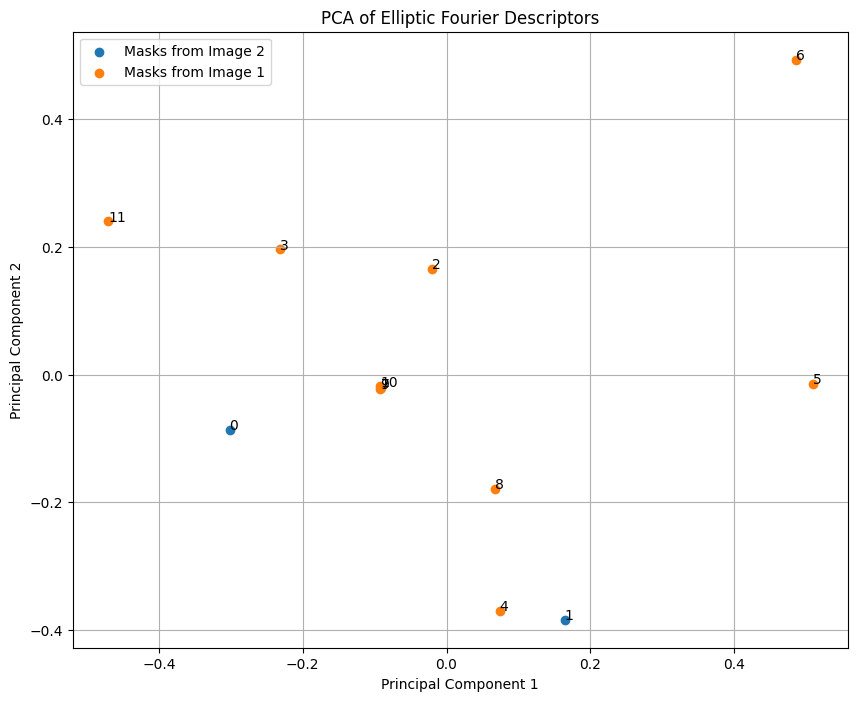

In [174]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Flatten and reshape all coefficients from both lists
all_coeffs_list = []
for coeffs in coeffs1 + coeffs2:
    all_coeffs_list.append(np.array(coeffs).flatten())

# Find the maximum length of the flattened coefficient arrays
max_len = max(len(coeffs) for coeffs in all_coeffs_list)

# Pad all flattened coefficient arrays to the maximum length
all_coeffs_padded = []
for coeffs in all_coeffs_list:
    padding_size = max_len - len(coeffs)
    padded_coeffs = np.pad(coeffs, (0, padding_size), 'constant')
    all_coeffs_padded.append(padded_coeffs)

# Stack the padded coefficient arrays into a single numpy array
all_coeffs_stacked = np.vstack(all_coeffs_padded)

# Perform PCA
# Choose the number of components based on the number of samples and features
n_components = min(all_coeffs_stacked.shape[0], all_coeffs_stacked.shape[1])
if n_components > 1:
    pca = PCA(n_components=2) # Use 2 components for a 2D scatter plot if possible
    principal_components = pca.fit_transform(all_coeffs_stacked)

    print("Principal Components:\n", principal_components)
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    # Plot the PCA results
    plt.figure(figsize=(10, 8))
    # Distinguish between coefficients from coeffs1 and coeffs2 in the plot
    num_coeffs1 = len(coeffs1)
    plt.scatter(principal_components[:num_coeffs1, 0], principal_components[:num_coeffs1, 1], label='Masks from Image 2')
    plt.scatter(principal_components[num_coeffs1:, 0], principal_components[num_coeffs1:, 1], label='Masks from Image 1')


    for i, txt in enumerate(principal_components):
      plt.annotate(i, (principal_components[i, 0], principal_components[i, 1]))

    #
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Elliptic Fourier Descriptors')
    plt.legend()
    plt.grid(True)
    plt.show()
elif n_components == 1:
    pca = PCA(n_components=1)
    principal_components = pca.fit_transform(all_coeffs_stacked)
    print("Principal Components:\n", principal_components)
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    plt.figure(figsize=(10, 4))
    num_coeffs1 = len(coeffs1)
    plt.scatter(principal_components[:num_coeffs1, 0], np.zeros(num_coeffs1), label='Masks from Image 2')
    plt.scatter(principal_components[num_coeffs1:, 0], np.zeros(len(coeffs2)), label='Masks from Image 1')
    plt.xlabel('Principal Component 1')
    plt.title('PCA of Elliptic Fourier Descriptors (1 Component)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data points or features to perform PCA.")

In [ ]:
#git clone https://github.com/DBraun/turning-function.git

%cd turning-function
!ls
!pip install -e .
%cd ..

/content/turning-function
pyproject.toml	test-requirements.txt
README.md	tests
setup.py	turning_function.cpython-312-x86_64-linux-gnu.so
src		turning_function.egg-info
Obtaining file:///content/turning-function
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for turning_function (pyproject.toml) ... done
  Created wheel for turning_function: filename=turning_function-0.0.3-0.editable-cp312-cp312-linux_x86_64.whl size=3625 sha256=b44107bad49cf4f7a9c8c82d3739189140cb434aa5a7582d0591e8bc7debb965
  Stored in directory: /tmp/pip-ephem-wheel-cache-hf_8z1d2/wheels/ec/7a/0e/6502b32fc202064062af819315dbe6e4aaaf71d0cf72026c07
Successfully built turning_function
  Attempting uninstall: turning_function
    Found existing installation: turning_function 0.0.3
    Uninstalling turning_function-0.0.3:
      Successfully uni

In [ ]:
#elliptic fourier descriptor doesnt work well for complex shape, lets try turning distance

import turning_function
shapes1=[]
shapes2=[]
print(len(contours1))
for c in contours1:
  l = []

  for p in c[0]:


    l.append(p[0])
  shapes1.append(l)
for c in contours2:
  l = []

  for p in c[0]:
    l.append(p[0])
  shapes2.append(l)
print(len(shapes2[0]))
print(len(shapes1[0]))
print(turning_function.max_points)
turning_function.distance(shapes1[0], shapes2[0][:1024])
for i in range(len(shapes1)):
  for j in range(len(shapes2)):
    print(turning_function.distance(shapes1[i][:1024], shapes2[j][:1024])[0])


10
1035
912
1024
1.5577262872989288
1.2155050484855514
1.1798303961025218
0.8778438987526546
1.6060644850359427
1.0047714696768992
1.3238426814407882
0.7220423205677228
1.0672484762701862
0.849923813905453
1.5618892491323413
0.7227666834388166
1.452484881351811
0.7367746495280794
1.570697244384608
0.6995991599633483
1.5685401677841204
0.7121083071920975
1.5508820372838903
0.9260917947288093


In [ ]:
!pip install -r requirements.txt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 32.9 MB/s eta 0:00:00


In [ ]:


import pickle
import os
import urllib

import numpy as np
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from tqdm import tqdm
DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")


DINOv3 location set to facebookresearch/dinov3


In [ ]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"
from huggingface_hub import notebook_login

# we take DINOv3 ViT-L
MODEL_NAME = MODEL_DINOV3_VITL

import torch
from transformers import AutoImageProcessor, AutoModel
from transformers.image_utils import load_image



pretrained_model_name = "facebook/dinov3-vitl16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(
    pretrained_model_name,
    device_map="auto",
)
model.cuda()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

DINOv3ViTModel(
  (embeddings): DINOv3ViTEmbeddings(
    (patch_embeddings): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (rope_embeddings): DINOv3ViTRopePositionEmbedding()
  (layer): ModuleList(
    (0-23): 24 x DINOv3ViTLayer(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attention): DINOv3ViTAttention(
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (o_proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (layer_scale1): DINOv3ViTLayerScale()
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): DINOv3ViTMLP(
        (up_proj): Linear(in_features=1024, out_features=4096, bias=True)
        (down_proj): Linear(in_features=4096, out_features=1024, bias=True)
        (act_fn): GELUA

In [ ]:
from PIL import Image
import numpy as np

def binary_mask_to_rgba_image(mask: np.ndarray, color: tuple = (255, 255, 255)) -> Image.Image:
    """
    Converts a binary mask (NumPy array) to a Pillow RGBA Image.

    Args:
        mask: A 2D NumPy array representing the binary mask (values 0 or 1, or 0-255).
        color: A tuple representing the RGB color for the non-transparent areas (0-255).

    Returns:
        A Pillow RGBA Image.
    """
    # Ensure mask is in the correct format (e.g., boolean or uint8 0-255)
    if mask.dtype == bool:
        mask = mask.astype(np.uint8) * 255
    elif mask.max() <= 1:
         mask = mask.astype(np.uint8) * 255


    # Create an image with the specified color
    rgb_layer = Image.new('RGB', (mask.shape[1], mask.shape[0]), color)

    # Use the mask as the alpha channel
    alpha_layer = Image.fromarray(mask, mode='L')

    # Merge the RGB layer and the alpha layer
    rgba_image = Image.merge('RGBA', (rgb_layer.split()[0], rgb_layer.split()[1], rgb_layer.split()[2], alpha_layer))

    return rgba_image

# Example usage (assuming you have a binary mask called 'skimage_masks[0]'):
# rgba_mask_image = binary_mask_to_rgba_image(skimage_masks[0])
# rgba_mask_image.show() # To display the image (might require a display environment)
# or save the image:
# rgba_mask_image.save("mask_rgba.png")

In [ ]:
image_left = Image.open("images/image4.jpg")
print(image_left)
mask_left =  binary_mask_to_rgba_image(masks[0])


image_right = Image.open("images/image3.jpg")
mask_right = binary_mask_to_rgba_image(masks2[0])





<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=800x529 at 0x7E3376FAB050>


/tmp/ipython-input-2976418632.py:26: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  alpha_layer = Image.fromarray(mask, mode='L')


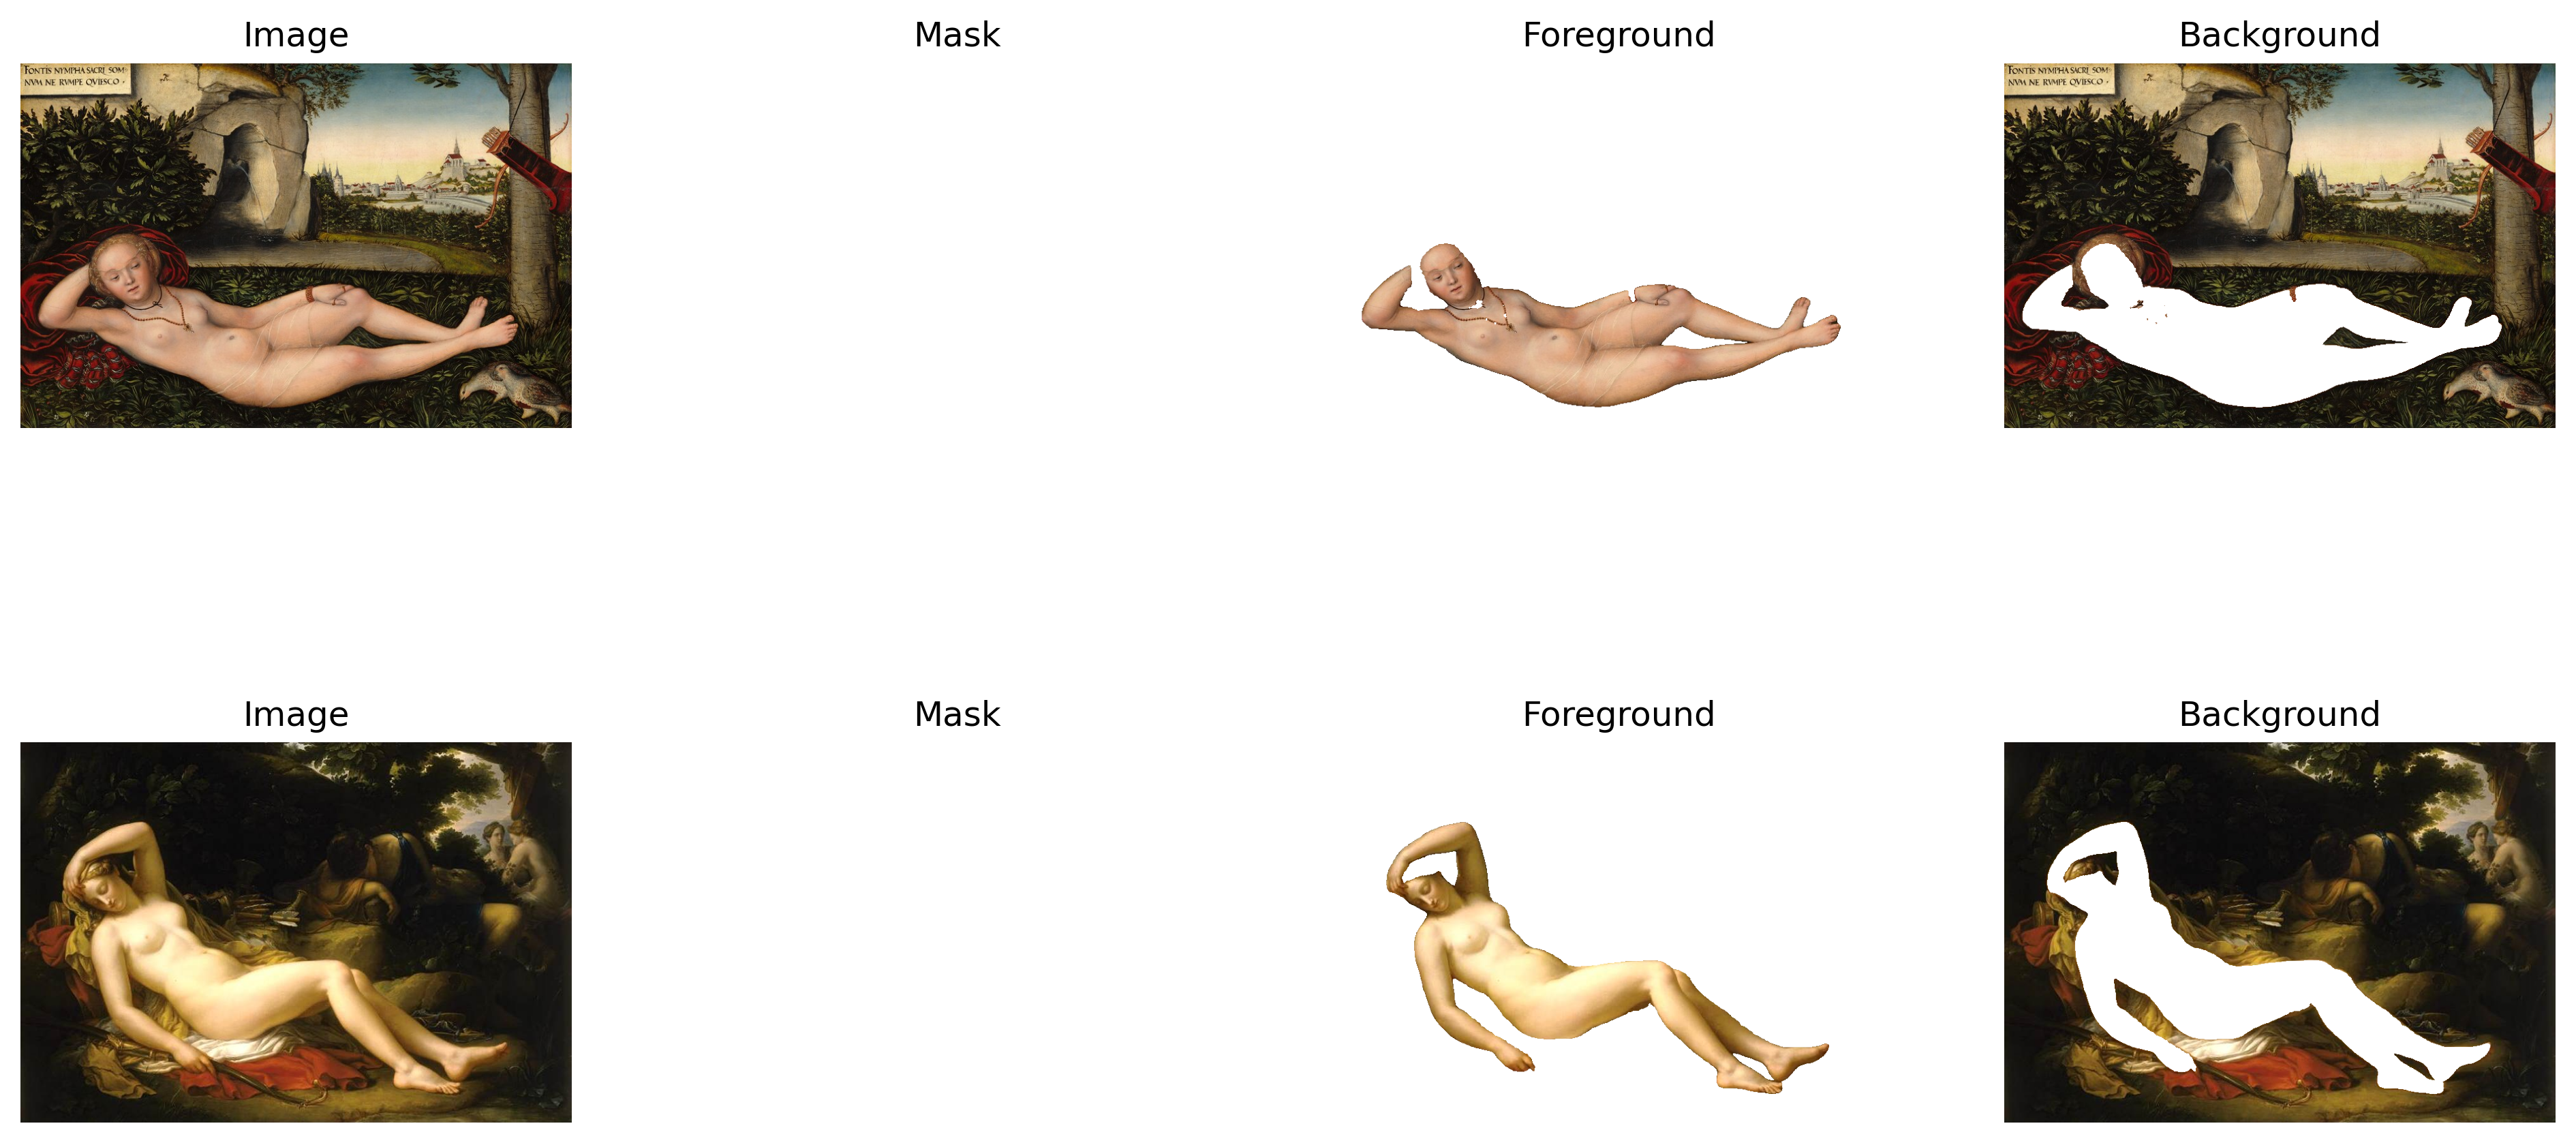

In [ ]:


plt.figure(figsize=(16, 8), dpi=300)

for j, (image, mask) in enumerate([(image_left, mask_left), (image_right, mask_right)]):
    foreground = Image.composite(image, mask, mask)
    mask_bg_np = np.copy(np.array(mask))
    mask_bg_np[:, :, 3] = 255 - mask_bg_np[:, :, 3]
    mask_bg = Image.fromarray(mask_bg_np)
    background = Image.composite(image, mask_bg, mask_bg)

    data_to_show = [image, mask, foreground, background]
    data_labels = ["Image", "Mask", "Foreground", "Background"]


    for i in range(len(data_to_show)):
        plt.subplot(2, len(data_to_show), 4 * j + i + 1)
        plt.imshow(data_to_show[i])
        plt.axis('off')
        plt.title(data_labels[i], fontsize=12)

plt.show()



In [ ]:


PATCH_SIZE = 16
IMAGE_SIZE = 768

# quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

# image resize transform to dimensions divisible by patch size
def resize_transform(
    mask_image: Image,
    image_size: int = IMAGE_SIZE,
    patch_size: int = PATCH_SIZE,
) -> torch.Tensor:
    w, h = mask_image.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))



In [ ]:


IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

patch_mask_values = []
patch_features = []

with torch.inference_mode():
    with torch.autocast(device_type='cuda', dtype=torch.float32):
        for image, mask in tqdm([(image_left, mask_left), (image_right, mask_right)], desc="Processing images"):
            # processing mask
            mask = mask.split()[-1]
            mask_resized = resize_transform(mask)
            mask_quantized = patch_quant_filter(mask_resized).squeeze().view(-1).detach().cpu()
            #mask_quantized = patch_quant_filter(mask_resized).squeeze().detach().cpu()
            patch_mask_values.append(mask_quantized)
            # processing image
            image = image.convert('RGB')
            image_resized = resize_transform(image)
            image_resized = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
            image_resized = image_resized.unsqueeze(0).cuda()

            feats = model.get_intermediate_layers(image_resized, n=range(n_layers), reshape=True, norm=True)
            dim = feats[-1].shape[1]
            patch_features.append(feats[-1].squeeze().view(dim, -1).permute(1,0).detach().cpu())
            #patch_features.append(feats[-1].squeeze().detach().cpu())



Processing images:   0%|          | 0/2 [00:00<?, ?it/s]


AttributeError: 'DINOv3ViTModel' object has no attribute 'get_intermediate_layers'